In [1]:
from glob import glob
from math import sqrt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Reshape, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# Dataset preprocessing
# Only needs to be run once, Tyler ran it already

# DATA_DIR = "/hdd/datasets/UTKFace"
# image_paths = glob(DATA_DIR + "/*")

# images = np.zeros((len(image_paths), 96, 96, 3), dtype=np.float32)
# for i, image_path in enumerate(image_paths):
#     image = Image.open(image_path)
#     image = image.resize((96, 96), Image.LANCZOS)
#     images[i] = np.array(image) / 255.
# np.save("/hdd/datasets/UTKFace.npy", images)

In [3]:
# Loads numpy file containing dataset
images = np.load("/hdd/datasets/UTKFace.npy")

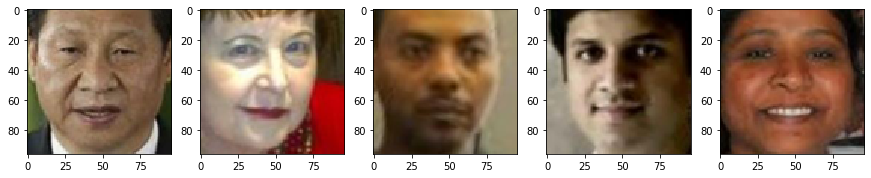

In [4]:
# Plots some sample images
fig, ax = plt.subplots(ncols=5, figsize=(15, 15))
for i, col in enumerate(ax):
    col.imshow(images[i])

In [5]:
def create_encoder(input_shape, encoding_dim):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(conv1)
    pool1 = MaxPool2D()(conv1)
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(conv2)
    pool2 = MaxPool2D()(conv2)
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(conv3)
    pool3 = MaxPool2D()(conv3)
    conv4 = Conv2D(256, 3, padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, 3, padding="same", activation="relu")(conv4)
    pool4 = MaxPool2D()(conv4)
    flatten = Flatten()(pool4)
    dense = Dense(encoding_dim, activation="softmax")(flatten)
    
    encoder = Model(inputs, dense)
    encoder.summary()
    
    return encoder

In [6]:
def create_decoder(encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
    
    inputs = Input(shape=encoding_dim)
    reshape = Reshape((int(sqrt(encoding_dim)), int(sqrt(encoding_dim)), 1))(inputs)
    conv1 = Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")(reshape)
    conv2 = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(conv2)
    conv4 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv3)
    conv5 = Conv2D(3, 3, padding="same", activation="sigmoid")(conv4)
    
    decoder = Model(inputs, conv5)
    decoder.summary()
    
    return decoder

In [7]:
input_shape = images[0].shape
encoding_dim = 36

In [8]:
encoder = create_encoder(input_shape, encoding_dim)
decoder = create_decoder(encoding_dim)

inputs = Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse")

W1104 15:56:10.119835 140315972155136 deprecation.py:506] From /opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0     

In [ ]:
autoencoder.fit(images, images, batch_size=128, epochs=25)

Epoch 1/25
23708/23708 [==============================] - 26s 1ms/sample - loss: 0.0579
Epoch 2/25
23708/23708 [==============================] - 20s 850us/sample - loss: 0.0566
Epoch 3/25
23708/23708 [==============================] - 20s 857us/sample - loss: 0.0563
Epoch 4/25
 5888/23708 [======>.......................] - ETA: 15s - loss: 0.0562

In [ ]:
visual = images[:5]
preds = autoencoder.predict(visual)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(visual[i])
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
    plt.xlabel("Reconstructed")
plt.show()